# MSBD5002 Assignment 3: Unsupervised learning of Images Segmentation

## Preparation

### Import Packages & Files

In [2]:
# Magic functions
% matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# PIL
from IPython.display import display
from PIL import Image


### Load images

In [3]:
# import images
def loadImageNames(dir_path):
    images_dict = []
    file_names = [file for file in os.listdir(dir_path)]
    file_names.sort(reverse=False)
    file_count = len(file_names)
    for name in file_names:
        images_dict.append({"names": name})
    
    df = pd.DataFrame(images_dict)
    return df

In [5]:
img_dir_path = './images'
img_names_df = loadImageNames(img_dir_path)
img_names_df.head()

,names
0,00000.jpg
1,00001.jpg
2,00002.jpg
3,00003.jpg
4,00004.jpg


## Features extraction by CovNets

In [6]:
# Keras
import keras
from keras.preprocessing import image as KerasImage

def predictImages(model, size, preprocess, decode_pred):
    '''
    Description: This function is mainly for predicting the types of the images
    Parameters:
        @model: the CovNet model used for prediction
        @size:  the size of the image for the ConNet
        @preprocess: the specific 'preprocess_input' function of the CovNet
        @decode_pred: the specific 'decode_prediction' function of the CovNet
    '''
    preds_arr = []
    n = len(img_names_df)
    n = 10
    
    # time calculation
    start = time.time()
    
    for name in img_names_df['names'][:n]:
        # Load the image
        path = os.path.join(img_dir_path, name)
        img = KerasImage.load_img(path, target_size=(size, size))
        
        # Preprocess the image
        x = KerasImage.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess(x)

        preds = model.predict(x)
        
        # Add the prediction to dataframe
        row = []
        for result in decode_pred(preds, top=3)[0]:
            # append class name
            row.append(result[1])
            
            # append class prediction probability
            row.append(result[2])
            
        # Add row to the prediction array
        preds_arr.append(row)
    
    # total time
    end = time.time()
    print("Prediction time: {}".format(end - start))
    
     # transform to DataFrame
    indice = list(img_names_df['names'].str.replace(".jpg", ""))
    columns = ["class1", "P(class1)", "class2", "P(class2)", "class3", "P(class3)"]
    preds_df = pd.DataFrame(preds_arr, index=indice[:n], columns=columns)
    
    return preds_df

Using TensorFlow backend.


In [8]:
def featuresExtraction(model, size, preprocess):
    '''
    Description: This function is mainly for features extraction of the images
    Parameters:
        @model: the CovNet model used for prediction
        @size:  the size of the image for the ConNet
        @preprocess: the specific 'preprocess_input' function of the CovNet
    '''
    features_arr = []
    n = len(img_names_df)
#     n = 10

    # time calculation
    start = time.time()
    
    for name in img_names_df['names'][:n]:
        # Load the image
        path = os.path.join(img_dir_path, name)
        img = KerasImage.load_img(path, target_size=(size, size))
        
        # Preprocess the image
        x = KerasImage.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess(x)

        # Extract features
        features = model.predict(x)
        
        # Flatten the array
        flat_features = features.flatten()
        
        # Add the features to array
        features_arr.append(flat_features)
        
    # get the total time
    end = time.time()
    total_minutes = float(end - start) / 60.
    print("Features extraction minutes: {}".format(total_minutes))
    
    # transform the array to dataframe
#     features_df = pd.DataFrame(features_arr)
    
    return features_arr


### VGG16

In [86]:
# import modules
from keras.applications.vgg16 import decode_predictions as vgg16_decode
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from keras.applications.vgg16 import VGG16

# define the size
vgg16_size = 224


In [28]:
# Predict the images' class
vgg16_predictor = VGG16(include_top=True, weights='imagenet')
vgg16_predictions = predictImages(model=vgg16_predictor,
                                   size=vgg16_size,
                                   preprocess=vgg16_preprocess,
                                   decode_pred=vgg16_decode)
display(vgg16_predictions)

553467904/553467096 [==============================] - 481s 1us/step


,class1,P(class1),class2,P(class2),class3,P(class3)
00000,peacock,0.377568,vulture,0.232632,black_stork,0.100799
00001,patio,0.446481,boathouse,0.207077,canoe,0.056574
00002,goose,0.124013,Indian_cobra,0.113438,drake,0.066087
00003,canoe,0.870046,sandbar,0.033237,paddle,0.025013
00004,electric_guitar,0.098362,shopping_basket,0.071063,shopping_cart,0.070547
00005,ruffed_grouse,0.162827,jay,0.120861,quail,0.119565
00006,bearskin,0.126168,bubble,0.043872,gong,0.036369
00007,space_heater,0.397165,radiator,0.130882,printer,0.031022
00008,Siamese_cat,0.997221,Egyptian_cat,0.002413,Chihuahua,0.000187
00009,drilling_platform,0.491829,fireboat,0.204176,container_ship,0.052577


In [87]:
# Features extraction
vgg16_transformer = VGG16(weights="imagenet", include_top=False)


In [ ]:
vgg16_features = featuresExtraction(vgg16_transformer, vgg16_size, vgg16_preprocess)

### ResNet50

In [9]:
# import modules
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet_preprocess
from keras.applications.resnet50 import decode_predictions as resnet_decode

# define the image size
resnet_size = 224


In [10]:
# Predict the images' class
resnet_predictor = ResNet50(include_top=True, weights='imagenet')
resnet_predictions = predictImages(model=resnet_predictor,
                                   size=resnet_size,
                                   preprocess=resnet_preprocess,
                                   decode_pred=resnet_decode)
display(resnet_predictions)

Prediction time: 1.57790207862854


,class1,P(class1),class2,P(class2),class3,P(class3)
00000,black_stork,0.312974,vulture,0.126175,koala,0.110224
00001,barrow,0.371255,grand_piano,0.210058,patio,0.141288
00002,slug,0.734239,boa_constrictor,0.040971,quail,0.036241
00003,canoe,0.634652,paddle,0.220948,speedboat,0.089380
00004,shopping_cart,0.151699,shopping_basket,0.097454,spatula,0.090211
00005,African_grey,0.645125,mongoose,0.078653,eel,0.044929
00006,cowboy_hat,0.231403,abaya,0.128040,harmonica,0.041996
00007,groenendael,0.510088,schipperke,0.132408,radiator,0.076450
00008,Siamese_cat,0.995259,window_screen,0.002817,Egyptian_cat,0.001019
00009,drilling_platform,0.962140,container_ship,0.008455,liner,0.006559


In [11]:
# Features extraction
resnet_transformer = ResNet50(weights="imagenet", include_top=False)

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [83]:
resnet_features = featuresExtraction(resnet_transformer, resnet_size, resnet_preprocess)

Features extraction minutes: 9.532294698556264


### Xception

In [14]:
# import modules
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess
from keras.applications.xception import decode_predictions as xception_decode

# define the image size
xception_size = 299

In [25]:
# Predict the images' class
xception_predictor = Xception(include_top=True, weights='imagenet')
xception_predictions = predictImages(model=xception_predictor,
                                   size=xception_size,
                                   preprocess=xception_preprocess,
                                   decode_pred=xception_decode)
display(xception_predictions)

,class1,P(class1),class2,P(class2),class3,P(class3)
00000,black_stork,0.281189,limpkin,0.138756,white_stork,0.137013
00001,patio,0.507141,horse_cart,0.101965,oxcart,0.070453
00002,kite,0.734416,goldfinch,0.020303,macaw,0.013203
00003,speedboat,0.366849,paddle,0.304516,canoe,0.056017
00004,shopping_basket,0.543007,hamper,0.077754,tricycle,0.045767
00005,African_grey,0.668332,vulture,0.091122,albatross,0.025742
00006,schipperke,0.066566,American_black_bear,0.048919,prison,0.021901
00007,space_heater,0.885888,Egyptian_cat,0.017458,printer,0.014848
00008,Siamese_cat,0.939057,window_screen,0.006235,doormat,0.003726
00009,drilling_platform,0.485906,aircraft_carrier,0.112375,container_ship,0.088699


In [15]:
# Features extraction
xception_transformer = Xception(weights="imagenet", include_top=False)

In [16]:
xception_features = featuresExtraction(xception_transformer, xception_size, xception_preprocess)
print(xception_features[0])

Features extraction minutes: 15.042704033851624
[0. 0. 0. ... 0. 0. 0.]


### InceptionResNetV2

In [60]:
# import modules
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as inception_preprocess
from keras.applications.inception_resnet_v2 import decode_predictions as inception_decode

# define the image size
inception_size = 299

In [61]:
# Predict the images' class
inception_predictor = InceptionResNetV2(include_top=True, weights='imagenet')
inception_predictions = predictImages(model=inception_predictor,
                                   size=inception_size,
                                   preprocess=inception_preprocess,
                                   decode_pred=inception_decode)
display(inception_predictions)

Prediction time: 16.088445901870728


,class1,P(class1),class2,P(class2),class3,P(class3)
00000,limpkin,0.354209,redshank,0.184044,black_stork,0.116822
00001,patio,0.934444,restaurant,0.018608,lakeside,0.009297
00002,brambling,0.258900,goldfinch,0.257969,kite,0.090909
00003,speedboat,0.198967,paddle,0.109394,sandbar,0.104126
00004,power_drill,0.211188,shopping_basket,0.189919,screwdriver,0.143631
00005,African_grey,0.957284,vulture,0.007387,albatross,0.001660
00006,cowboy_hat,0.593928,ox,0.192778,worm_fence,0.035793
00007,space_heater,0.958563,radiator,0.003036,electric_fan,0.000789
00008,Siamese_cat,0.906933,Egyptian_cat,0.001990,lynx,0.000994
00009,drilling_platform,0.894426,aircraft_carrier,0.033702,container_ship,0.025612


In [ ]:
inception_transformer = InceptionResNetV2(weights="imagenet", include_top=False)

In [73]:
inception_features = featuresExtraction(inception_transformer, inception_size, inception_preprocess)
display(inception_features.head())

Features extraction minutes: 23.43153581619263


,0,1,2,3,4,5,6,7,8,9,...,98294,98295,98296,98297,98298,98299,98300,98301,98302,98303
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.161820,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,1.205772,0.000000,1.876668,0.000000,0.000000,0.511738,0.000000,0.097872,1.742356,0.101525
2,0.531742,0.000000,0.000000,0.0,0.135945,0.000000,0.0,0.000000,0.000000,0.000000,...,0.348137,0.967040,0.000000,0.276122,0.876260,0.243328,0.000000,0.675683,1.031659,0.000000
3,0.000000,0.000000,0.154089,0.0,0.000000,0.000000,0.0,0.203061,0.000000,0.124394,...,0.000000,0.210872,0.173454,0.000000,0.160510,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.293457,0.000000,0.0,0.000000,1.365147,0.0,0.000000,1.020301,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.206946,0.000000,0.079383,0.000000,0.000000,0.000000


## Dimensions Reduction

Since there are still many features after features extraction, I will try to apply PCA to reduce the dimensions.

In [19]:
from sklearn.decomposition import PCA

def pca_transform(features_df, n_components=None):
    # PCA transformation
    pca = PCA(n_components=n_components, random_state=728)
    output = pca.fit_transform(features_df)
    
    # plot the cumulative explained variance plot
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()
    
    return pca, output

### InceptionResNetV2

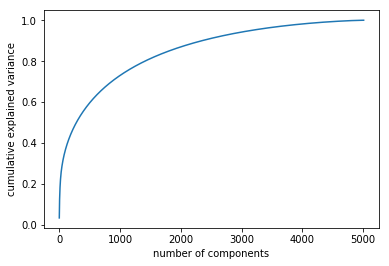

(5011, 5011)

In [78]:
inception_pca, inception_pca_features = pca_transform(inception_features)
inception_pca_df = pd.DataFrame(inception_pca_features)
inception_pca_df.shape

In [ ]:
# store to file
inception_pca_df.to_csv("inception_pca.csv", index=False)

### ResNet50

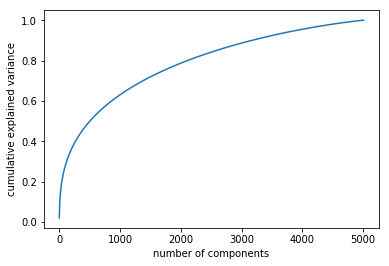

(5011, 5011)

In [93]:
resnet_pca, resnet_pca_features = pca_transform(resnet_features)
resnet_pca_df = pd.DataFrame(resnet_pca_features)
resnet_pca_df.shape

### VGG16

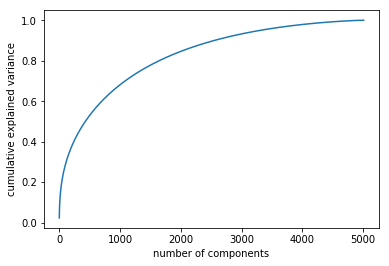

(5011, 5011)

In [94]:
vgg16_pca, vgg16_pca_features = pca_transform(vgg16_features)
vgg16_pca_df = pd.DataFrame(vgg16_pca_features)
vgg16_pca_df.shape

### Xception

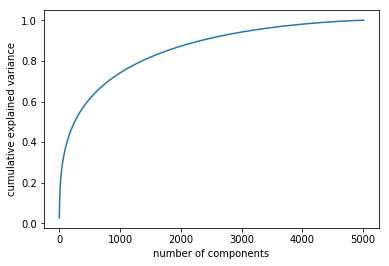

(5011, 5011)

In [132]:
xception_pca, xception_pca_features = pca_transform(xception_features)
xception_pca_df = pd.DataFrame(xception_pca_features)
xception_pca_df.shape

## Clustering

### Find out the suitable CovNet & K value

In [23]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

def silhouetteScore(dimension, pca_data, k_range):
    # Select the top N features
    train_data = []
    for i in range(len(pca_data)):
        train_data.append(pca_data[i][:dimension])

    train_data = np.array(train_data)
    print(train_data.shape)

    # Get the silhouette score list
    silhouette_list = []
    print("\n### Using the method of KMeans:")
    for n_clusters in k_range:
        clusterer = KMeans(n_clusters=n_clusters, algorithm="elkan", random_state=0).fit(train_data)
        preds = clusterer.predict(train_data)
        centers = clusterer.cluster_centers_
        score = silhouette_score(train_data, preds)
        silhouette_list.append(score)
        print("n_clusters = {}, silhouette_score: {:.4f}".format(n_clusters, score))

    return silhouette_list


In [ ]:
# Compute the silhouette score with different CovNets PCA features
k_range = range(10, 30, 2)
inception_silhouette_scores = silhouetteScore(3000, inception_pca_features, k_range)
resnet_silhouette_scores = silhouetteScore(3000, resnet_pca_features, k_range)
vgg16_silhouette_scores = silhouetteScore(3000, vgg16_pca_features, k_range)
xception_silhouette_scores = silhouetteScore(3000, xception_pca_features, k_range)


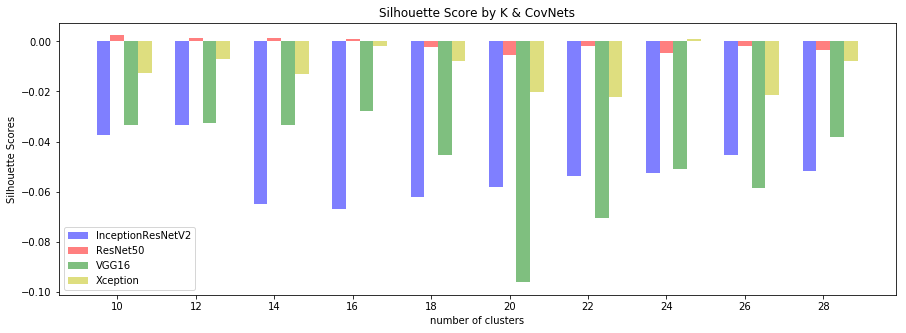

In [176]:
# Credit: Josh Hemann

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


n_clusters = len(resnet_silhouette_scores)
silhouette_scores = [inception_silhouette_scores,
                    resnet_silhouette_scores,
                    vgg16_silhouette_scores,
                    xception_silhouette_scores]


fig, ax = plt.subplots(figsize=(15, 5))

index = np.arange(3, 4*n_clusters, 4)
bar_width = 0.7

opacity = 0.5
error_config = {'ecolor': '0.3'}

labels_list = ['InceptionResNetV2', 'ResNet50', 'VGG16', 'Xception']
colors = ['b', 'r', 'g', 'y']
means = [means_men, means_women]

for i, (score, color, label) in enumerate(zip(silhouette_scores, colors, labels_list)):
    rects1 = ax.bar(x=index + bar_width*i,
                    height=score,
                    width=bar_width,
                    alpha=opacity,
                    color=color,
                    error_kw=error_config,
                    label=label)


ax.set_xlabel('number of clusters')
ax.set_ylabel('Silhouette Scores')
ax.set_title('Silhouette Score by K & CovNets')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(list(k_range))
ax.legend()

# fig.tight_layout()
plt.show()

### ResNet50 with 16 clusters

From the above picture, it is quite obvious that **ResNet50** can lead to a relatively high silhouette score. Thus, we will choose the PCA Featreus from ResNet50 to make some prediction.

#### Optimal K in Elbow Curve 

In [107]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

def draw_elbow_curve(dimension, pca_data, elbow_range):
    # define the pca data
    pca_data = inception_pca_features

    # define the training data
    train_data = []
    for i in range(len(pca_data)):
        train_data.append(pca_data[i][:dimension])
    train_data = np.array(train_data)

    distortions = []
    for k in elbow_range:
        print("======={}========".format(k))
        kmeanModel = KMeans(n_clusters=k, algorithm="elkan", random_state=0)
        kmeanModel.fit(train_data)
        distortions.append(sum(np.min(cdist(train_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / train_data.shape[0])

    # Plot the elbow
    plt.plot(elbow_range, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()


=======10========
=======12========
=======14========
=======16========
=======18========
=======20========
=======22========
=======24========
=======26========
=======28========


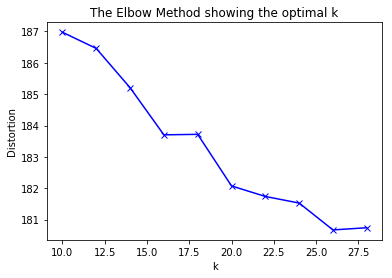

In [177]:
draw_elbow_curve(dimension=3000,
                 pca_data=resnet_pca_features,
                 elbow_range=k_range)

From the elbow curve, it's quite obvious that **16** can be the elbow value. Thus, we will choose 16 clusters for prediction.

#### KMeans Clustering

In [242]:
def KMeansClustering(k, dimension, pca_data):
    # define the training data
    train_data = []
    for i in range(len(pca_data)):
        train_data.append(pca_data[i][:dimension])
    
    train_data = np.array(train_data)
    
    # make predictions
    model = KMeans(n_clusters=k, n_jobs=-1, algorithm='elkan', random_state=100)
    model.fit(train_data)
    clusters_pred = model.predict(train_data)
    
    return clusters_pred
    

In [179]:
# make prediction with kmeans
kmeans_k = 16
kmeans_d = 3000
pca_data = resnet_pca_features
kmeans_pred = KMeansClustering(kmeans_k, kmeans_d, pca_data)


In [220]:
def PredictionDict(pred_arr, k):
    '''
    Get the dictionary from the predictions array
    ''' 
    # store the predictions into dictionary
    clusters_dict = {}
    
    # initialize the Series for each cluster key
    for i in range(k):
        clusters_dict[i] = []

    #   Key: the index of K
    # Value: the index string of the image
    for i, k_index in enumerate(pred_arr):
        value = img_names_df['names'][i].replace('.jpg', '')
        clusters_dict[k_index].append(value)
        
    # Transfer the value into Series so the dictionary
    # can be transformed into DataFrame
    for key, value in clusters_dict.items():
        clusters_dict[key] = pd.Series(value)
    
    return clusters_dict
        

In [ ]:
'''
Write the prediction result to file
'''
clusters_pred_dict = PredictionDict(kmeans_pred, kmeans_k)
clusters_pred_dict.keys()

clusters_cols_dict = {}
for i in range(kmeans_k):
    clusters_cols_dict[i] = 'cluster{}'.format(i+1)

clusters_pred_pd = pd.DataFrame.from_dict(clusters_pred_dict)
clusters_pred_pd = clusters_pred_pd.rename(clusters_cols_dict, axis='columns')

In [237]:
clusters_pred_pd.to_csv('resnet_predictions.csv', index=False)
clusters_pred_pd.head()

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,...,cluster15,cluster16,cluster17,cluster18,cluster19,cluster20,cluster21,cluster22,cluster23,cluster24
0,00000,00002,00046,00065,00018,00267,00017,00028,00019,00011,...,00025,00007,00035,00032,00012,00010,00001,00036,00137,00005
1,00013,00003,00248,00072,00022,00305,00066,00049,00024,00020,...,00044,00008,00057,00034,00031,00021,00006,00067,00213,00052
2,00014,00004,00300,00091,00026,00649,00082,00071,00027,00037,...,00079,00016,00064,00190,00038,00123,00015,00077,00277,00055
3,00047,00009,00325,00152,00104,00756,00111,00073,00033,00060,...,00088,00039,00095,00240,00048,00128,00029,00097,00285,00061
4,00051,00030,00551,00188,00105,00837,00182,00085,00189,00069,...,00161,00070,00100,00351,00099,00138,00042,00118,00296,00076


### Xception with 24 Clusters

From the silhouette score distribution bar chart, it is quite obvious that Xception with 24 clusters have a sudden increase. Thus, I would try 24 clusters with PCA features from Xception.

In [249]:
# make prediction with kmeans
kmeans_k = 24
kmeans_d = 3000
pca_data = xception_pca_features
xception_kmeans_pred = KMeansClustering(kmeans_k, kmeans_d, pca_data)

In [264]:
'''
Write the prediction result to file
'''
clusters_pred_dict = PredictionDict(xception_kmeans_pred, kmeans_k)
clusters_cols_dict = {}
for i in range(kmeans_k):
    clusters_cols_dict[i] = 'cluster{}'.format(i+1)

clusters_pred_pd = pd.DataFrame.from_dict(clusters_pred_dict)
clusters_pred_pd = clusters_pred_pd.rename(clusters_cols_dict, axis='columns')

In [ ]:
import math
xception_predictions_df = clusters_pred_pd.applymap(lambda x: '\'{}\''.format(x))
xception_predictions_df = xception_predictions_df.applymap(lambda x: '' if x=='\'nan\'' else x)
xception_predictions_df.to_csv("xception_predictions.csv", index=False)

### Comparision

Finally, I try to judge whether these 2 models are good by my own eyes. The following results is what I label the clusters.

#### ResNet50 PCA Clustering with KMeans
| Cluster | Label |
| :-----: | :---: |
| cluster1| plane |
| cluster2| cat, dog |
| cluster3| bus, train |
| cluster4| **NOT CLEAR** |
| cluster5| **NOT CLEAR** |
| cluster6| restaurant, dinner |
| cluster7| dogs, cows, sheep |
| cluster8| human faces |
| cluster9| bicycle, motorcycle |
|cluster10| living room |
|cluster11| people |
|cluster12| car |
|cluster13| birds |
|cluster14| bird |
|cluster15| horses |
|cluster16| **NOT CLEAR** |

#### Xception PCA Clustering with KMeans
| Cluster | Label |
| :-----: | :---: |
| cluster1| computers, work room |
| cluster2| car(for common drive) |
| cluster3| bus |
| cluster4| human |
| cluster5| horse |
| cluster6| restaurant |
| cluster7| train |
| cluster8| motorcyle |
| cluster9| living room |
|cluster10| **NOT CLEAR**(ship, animals) |
|cluster11| **NOT CLEAR** |
|cluster12| bicycle |
|cluster13| cat |
|cluster14| sport car |
|cluster15| human face |
|cluster16| dog |
|cluster17| car(street, park, road) |
|cluster18| plane |
|cluster19| sheep, cow |
|cluster20| car(more fancy) |
|cluster21| train |
|cluster22| bird |
|cluster23| motorcycle, bicycle |
|cluster24| dog, animals |

## Conclusion

From the above comparision, I would like to draw a conclusion that the clusters by Xception Features Extraction and KMeans clustering have a better images segmentations.

In [311]:
xception_predictions_df.to_csv("A3_dzhengah_20546139_prediction.csv", index=False)